In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

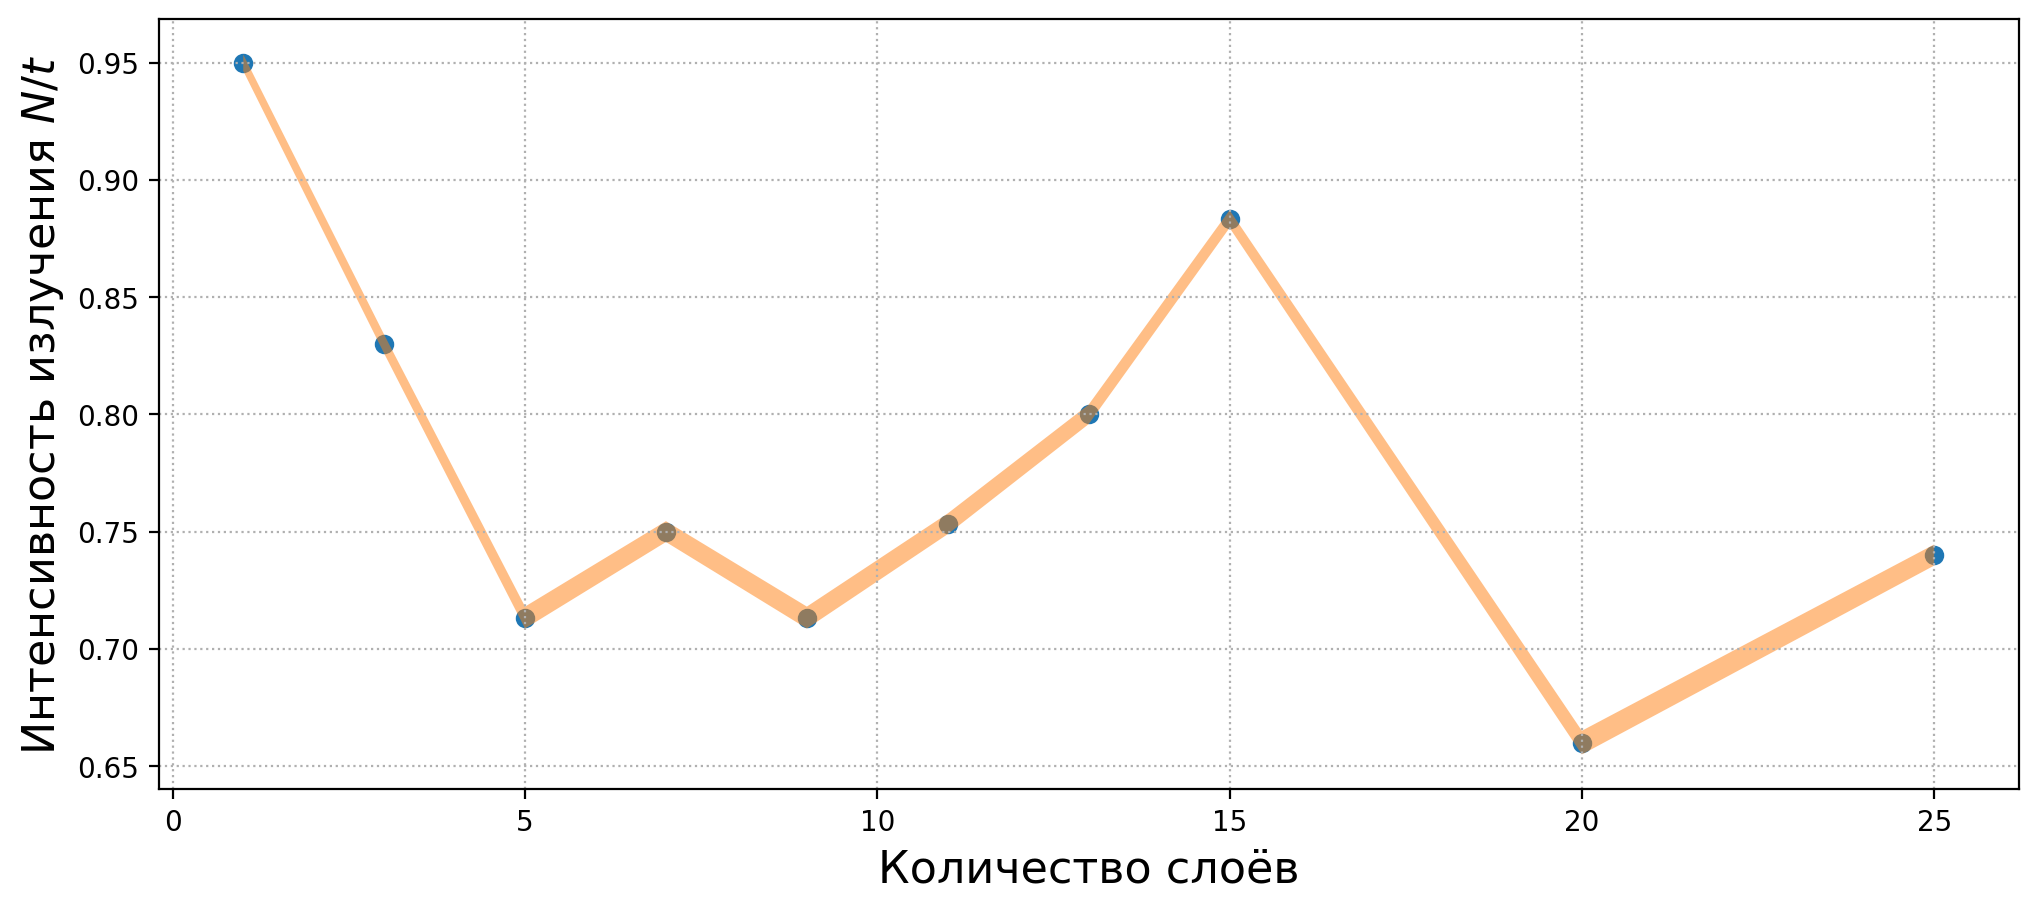

In [3]:
curve = pd.read_csv("curve.csv")

plt.figure(figsize = (12, 5), dpi = 200)
plt.scatter(curve.x, curve.N / curve.time)
plt.fill_between(curve.x, curve.N / curve.time + (1 / curve.N), curve.N / curve.time - (1 / curve.N), alpha = 0.5)

plt.ylabel("Интенсивность излучения $N/t$", fontsize = 16)
plt.xlabel("Количество слоёв", fontsize = 16)
plt.grid(ls = ':')

In [4]:
def curve_fit_func(x, a_line, b_line, a_exp, b_exp, c_exp, d):
    return (x < d) * a_exp * np.exp(b_exp * x) + c_exp + (x>=d) * x * a_line + b_line

In [5]:
param,_ = curve_fit(curve_fit_func, curve.x, curve.N / curve.time)
print(param[-1])

1.0000000014675734


/home/vladimir/BOTAY!/Labs/.venv/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


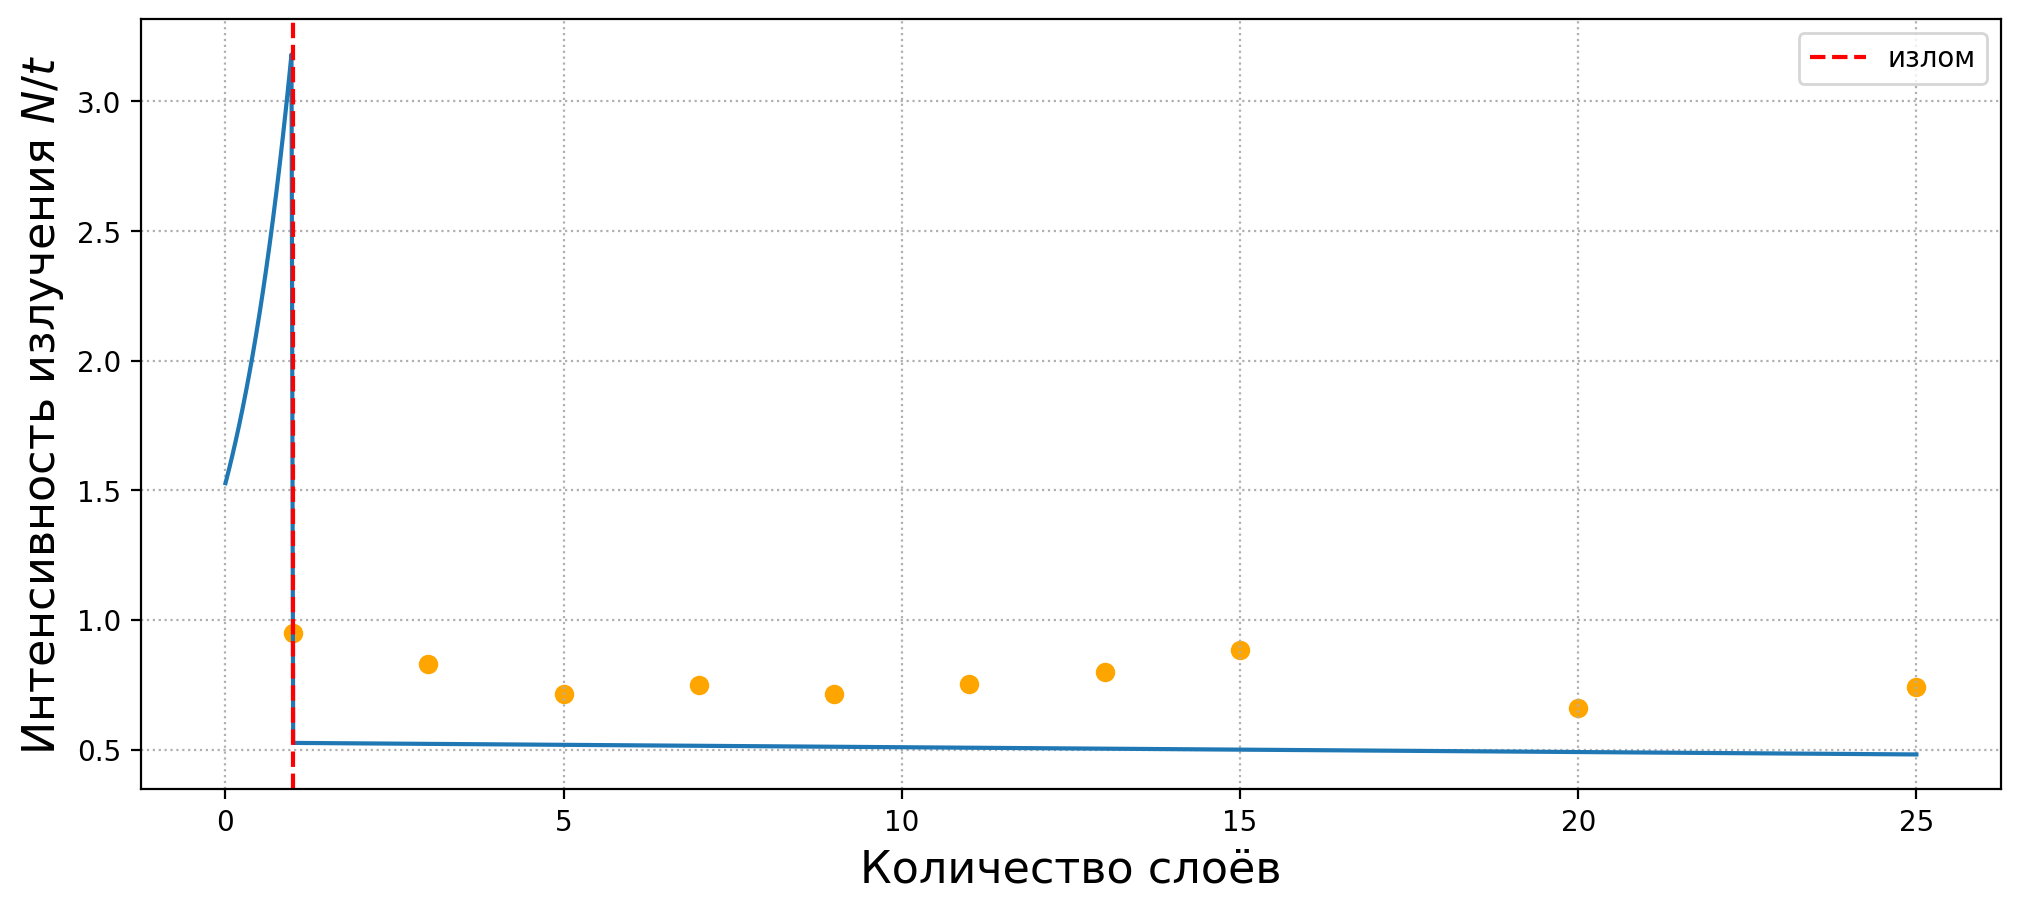

In [6]:
x_line = np.linspace(0, np.max(curve.x), 1000)
plt.figure(figsize = (12, 5), dpi = 200)
plt.grid(ls = ':')
plt.scatter(curve.x, curve.N / curve.time, color = 'orange')
plt.plot(x_line, curve_fit_func(x_line, *param))
plt.axvline(param[-1], color = 'red', label = 'излом', linestyle = '--')

plt.ylabel("Интенсивность излучения $N/t$", fontsize = 16)
plt.xlabel("Количество слоёв", fontsize = 16)
plt.legend()

### Угловой спектр

In [23]:
angle_spectrum = pd.read_csv("N_by_theta.csv")
angle_spectrum['Nbyt'] = angle_spectrum.N / angle_spectrum.time
angle_spectrum.head()

,N,theta,time,Nbyt
0,239,0,300,0.796667
1,258,10,300,0.860000
2,238,20,300,0.793333
3,202,30,361,0.559557
4,157,40,300,0.523333


In [52]:
def cos_power_n(theta, A, n):
    return A * np.power(np.cos(theta * np.pi / 180), n)

param, cov = curve_fit(cos_power_n, angle_spectrum.theta, angle_spectrum.Nbyt)
print(param)
theta_line = np.linspace(-10, 80, 1000)

[0.84205642 2.08849709]


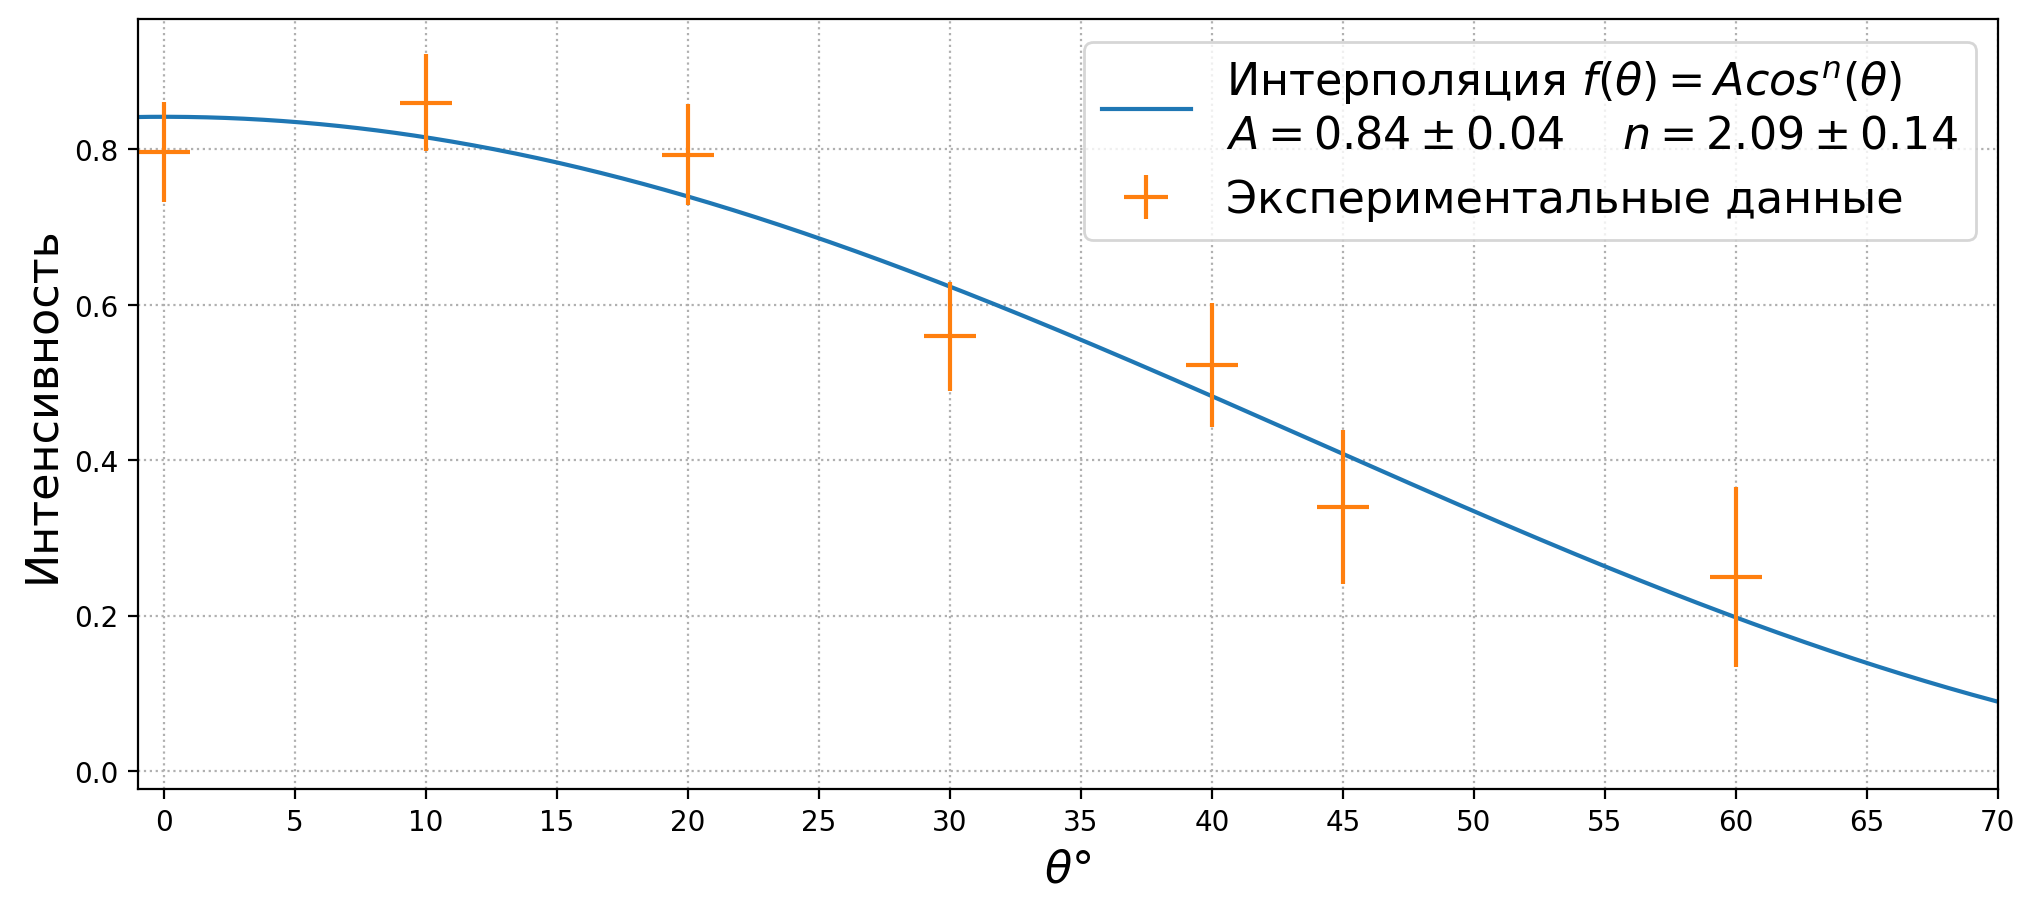

In [63]:
plt.figure(figsize = (12, 5), dpi = 200)
plt.plot(theta_line, 
         cos_power_n(theta_line, *param), 
         label = r'Интерполяция $f(\theta) = A cos^{n}(\theta)$' + f'\n$A = {param[0]:.2f} \pm {(np.diag(cov)[0] + 0.05 * param[0]):.2f} \ \ \ \ n = {param[1]:.2f} \pm {(np.diag(cov)[1] + 0.025 * param[1]):.2f}$')
plt.errorbar(angle_spectrum.theta, 
             angle_spectrum.N / angle_spectrum.time, 
             yerr = 1 / np.sqrt(angle_spectrum.N),
             xerr = [1 for _ in angle_spectrum.theta], 
             fmt = '_',
             label = 'Экспериментальные данные')
plt.xticks(np.arange(0, 75, 5))
plt.ylabel("Интенсивность", fontsize = 16)
plt.xlabel(r"$\theta \degree$", fontsize = 16)
plt.xlim(-1, 70)
plt.grid(ls = ':')
plt.legend(fontsize = 16)